# Self-Driving Car: Advanced Lane Finding
### Daniel Wolf
### January 2017


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import ntpath
%matplotlib inline

# 1) Camera Calibration

** Compute the camera calibration matrix and distortion coefficients given a set of chessboard images (in the camera_cal folder in the repository) **


In [2]:
# read in images
images = glob.glob('camera_cal/calibration*.jpg')
#print(images)

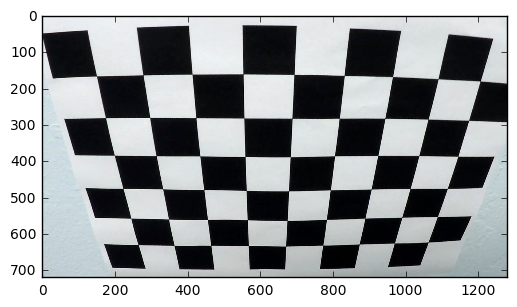

In [3]:
img = cv2.imread(images[len(images)-1])
plt.imshow(img)
plt.show()

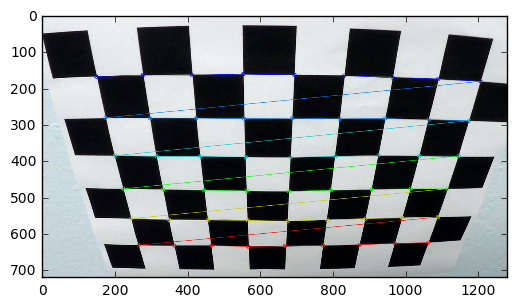

In [4]:
# Counting the number of inside corners in x and y as shown in the image above
nx = 9
ny = 6

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [5]:
# Arrays to store all the object points and image points from all the images
objpoints = []
imgpoints = []

# prepare object points, like (0,0,0), (1,0,0), (2,0,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    # read in each image
    img = cv2.imread(fname)
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        print(fname)
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        

camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg
camera_cal\calibration_ex.jpg


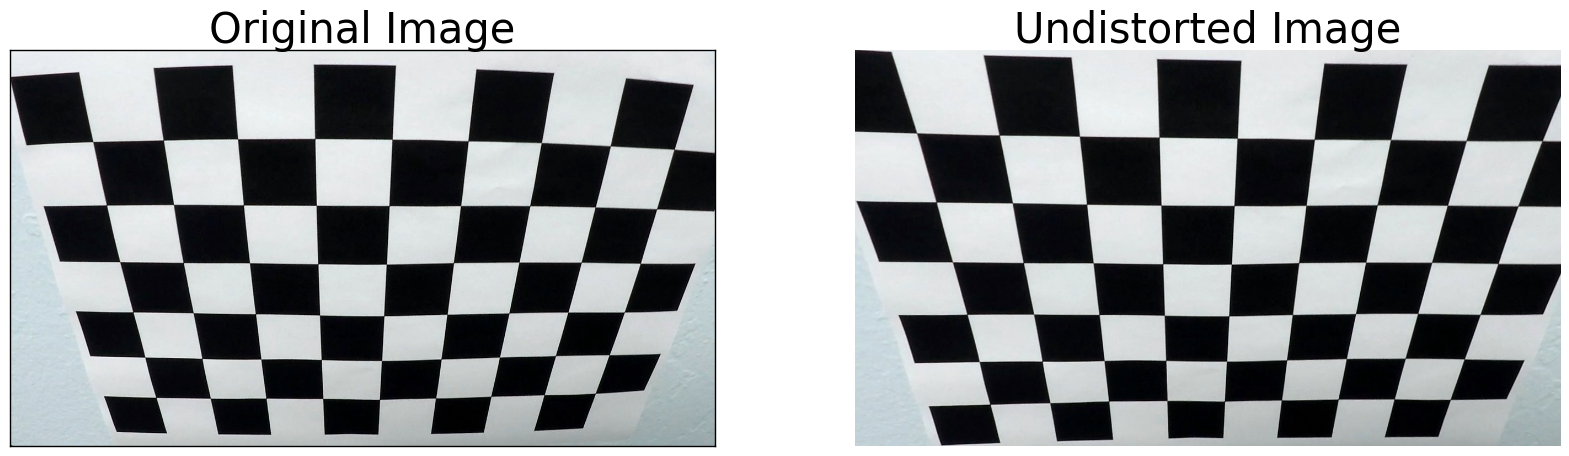

In [6]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration_ex.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Create undistortion
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Save
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.axis('off')

plt.savefig('submission/examples/chessboard_undistorted.jpg',bbox_inches='tight')


In [7]:
#########################################################

# 2) Advanced Lane Finding on Images

** Create a pipeline to add lane polygons to the images **

### Gradient Threshold Pipeline helper functions

In [8]:
# Directional gradient function
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# Gradient magnitude function
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

# Gradient direction function
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# Region masking
def region_of_interest(img, vertices):
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### Gradient Threshold Pipeline

In [9]:
# Define the pipeline for image processing
def threshold_pipeline(img):
    
    # Apply the distortion correction to the raw image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_undst = img
    
    # Apply Gaussian blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(25, 220))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(65, 220))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 220))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    
    # Combine the thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s_channel > 170) & (s_channel < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    # Factor for region masking
    fac = 1.65
    x_dim = np.shape(img)[1]
    y_dim = np.shape(img)[0]
    # Vertices for region masking
    vertices = np.array([[(0,y_dim), (x_dim,y_dim), (x_dim/2+10,y_dim/fac),
                          (x_dim/2-10,y_dim/fac)]], dtype = np.int32)

    
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary, img_undst


### Perspective Transformation

In [10]:
# Perspectivate transformation function
def perspective_transform(img, img_size):
    
    # Set the source points manually (trapezoid around the region of interest)
    src = np.float32([[575,470],[735,470],[1140,720],[210,720]])
    # Set the destination points manually
    dst = np.float32([[350,0],[930,0],[930,720],[350,720]])
    # Apply the perspective transformation
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size)#, flags=cv2.INTER_LINEAR)
    
    return warped, Minv
    

### Find and PolyFit Lane Lines

In [11]:

def find_lane_pts(warped):
    
    # Convert any pixel value above 0 to 1
    warped[warped > 0] = 1
    
    # Define some lengths that will be used for the histogram peaks
    h = warped.shape[0]
    onethird_h = np.int(h/3)
    twothird_h = np.int(h/3*2)
    w = warped.shape[1]
    half_w = np.int(w/2)
    
    # Split the image into thirds to evaluate
#    hist1 = np.sum(warped[:onethird_h,:], axis=0)
#    hist2 = np.sum(warped[onethird_h:twothird_h,:], axis=0)
#    hist3 = np.sum(warped[twothird_h:h,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    
    # Split the image vertically into thirds and horizontally in half
    hist_low_l = np.sum(warped[twothird_h:h , :half_w], axis=0)
    hist_low_r = np.sum(warped[twothird_h:h , half_w:w], axis=0)
    hist_mid_l = np.sum(warped[onethird_h:twothird_h , :half_w], axis=0)
    hist_mid_r = np.sum(warped[onethird_h:twothird_h , half_w:w], axis=0)
    hist_hi_l = np.sum(warped[:onethird_h , :half_w], axis=0)
    hist_hi_r = np.sum(warped[:onethird_h , half_w:w], axis=0)
    
    # Find the x-axis point for each vertical third and horizontal half
    x_low_l = np.argmax(hist_low_l)
    x_low_r = np.argmax(hist_low_r) + half_w
    x_mid_l = np.argmax(hist_mid_l)
    x_mid_r = np.argmax(hist_mid_r) + half_w
    x_hi_l = np.argmax(hist_hi_l)
    x_hi_r = np.argmax(hist_hi_r) + half_w
    
    # Define a new array that includes the coordinates for warped image shape
    coords = np.argwhere(warped)
    
    # Define width of sliding window
    x_window = 20
    # Create an array with left lane points by applying an x window on the low, mid, and hi thirds
    l_low = coords[(coords[:,1]>=x_low_l-x_window) & (coords[:,1]<x_low_l+x_window) &
                   (coords[:,0]<=h) & (coords[:,0]>=twothird_h)]
    l_mid = coords[(coords[:,1]>=x_mid_l-x_window) & (coords[:,1]<x_mid_l+x_window) &
                   (coords[:,0]<=twothird_h) & (coords[:,0]>=onethird_h)]
    l_hi = coords[(coords[:,1]>=x_hi_l-x_window) & (coords[:,1]<x_hi_l+x_window) &
                  (coords[:,0]<=onethird_h) & (coords[:,0]>=0)]
    left_lane_pts = np.concatenate((l_low, l_mid, l_hi), axis = 0)
    
    # Create an array with right lane points by applying an x window on the low, mid, and hi thirds
    r_low = coords[(coords[:,1]>=x_low_r-x_window) & (coords[:,1]<x_low_r+x_window) &
                   (coords[:,0]<=h) & (coords[:,0]>=twothird_h)]
    r_mid = coords[(coords[:,1]>=x_mid_r-x_window) & (coords[:,1]<x_mid_r+x_window) &
                   (coords[:,0]<=twothird_h) & (coords[:,0]>=onethird_h)]
    r_hi = coords[(coords[:,1]>=x_hi_r-x_window) & (coords[:,1]<x_hi_r+x_window) &
                  (coords[:,0]<=onethird_h) & (coords[:,0]>=0)]
    right_lane_pts = np.concatenate((r_low, r_mid, r_hi), axis = 0)
    
    return left_lane_pts, right_lane_pts


def fit_lanes(warped, left_lane_pts, right_lane_pts):
    
    # Define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    
    # Find the polynomial fit
    left_fit = np.polyfit(left_lane_pts[:,0], left_lane_pts[:,1], 2)
    right_fit = np.polyfit(right_lane_pts[:,0], right_lane_pts[:,1], 2)
    
    # Apply the polynomial fit to yvals
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    return left_fitx, right_fitx, yvals



### Curvature and Position

In [12]:
# Radius of Curvature: http://www.intmath.com/applications-differentiation/8-radius-curvature.php
# US Government Guidelines for Highways: http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
def curvature(yvals, fitx):
    
    y_eval = np.max(yvals)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    # Fit after converting to meters and apply curvature radius formula
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curve_rad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    
    return curve_rad

def position(left_fitx, right_fitx, img_width):
    
    # Get the x-coordinate from the left and right lane at the bottom of the image
    left_lane_pt = left_fitx[len(left_fitx)-1]
    right_lane_pt = right_fitx[len(right_fitx)-1]
    
    # Find the x-coordinate of the center of the lane
    center_x = (left_lane_pt + right_lane_pt) / 2
    
    # Find the center of the image (i.e the car's position)
    car_x = img_width / 2
    xm_per_pix = 3.7/700
    
    pos = (car_x - center_x) * xm_per_pix
    
    return pos


### Draw Output Image

In [13]:

def draw_polygon(image, warped, left_fitx, right_fitx, yvals):
    
    # Add the polygon onto the warped image with lines
    # Then convert back using inverse M
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Concatenate the left and right points to shape the polygon
    left_pts = np.array((left_fitx, yvals)).T
    right_pts = np.array((right_fitx, yvals)).T
    pts = np.concatenate((left_pts, np.flipud(right_pts)), axis = 0)
    # Fill the polygon with green
    cv2.fillPoly(color_warp, np.int32([pts]), (0, 255, 0))
    
    return color_warp


def draw_output(image, polyimage, Minv, curve, pos):
    
    # Inverse warp the polygon back to normal perspective
    warped_poly = cv2.warpPerspective(polyimage, Minv, (polyimage.shape[1], polyimage.shape[0]))
    
    # Add the polygon back on to the original image with transparency
    alpha = 0.35
    output = cv2.addWeighted(warped_poly, alpha, image, 1, 0)
    
    # Add Lane Radius of Curvature to output image
    curve_text = "Lane Radius of Curvature: " + str(int(curve)) + "m"
    cv2.putText(output,curve_text, (50,50), cv2.FONT_HERSHEY_TRIPLEX, 1, (255,255,255))
    
    # Add car's position in lane to output image
    if pos < 0:
        pos_text = "Car is " + str(round(abs(pos),2)) + "m left of lane center"
    elif pos > 0:
        pos_text = "Car is " + str(round(pos,2)) + "m right of lane center"
    else:
        pos_text = "Car is in the center of the lane"
    cv2.putText(output,pos_text, (50,100), cv2.FONT_HERSHEY_TRIPLEX, 1, (255,255,255))
    
    return output


### Process, Save, and Display Images!

test_images\test1.jpg


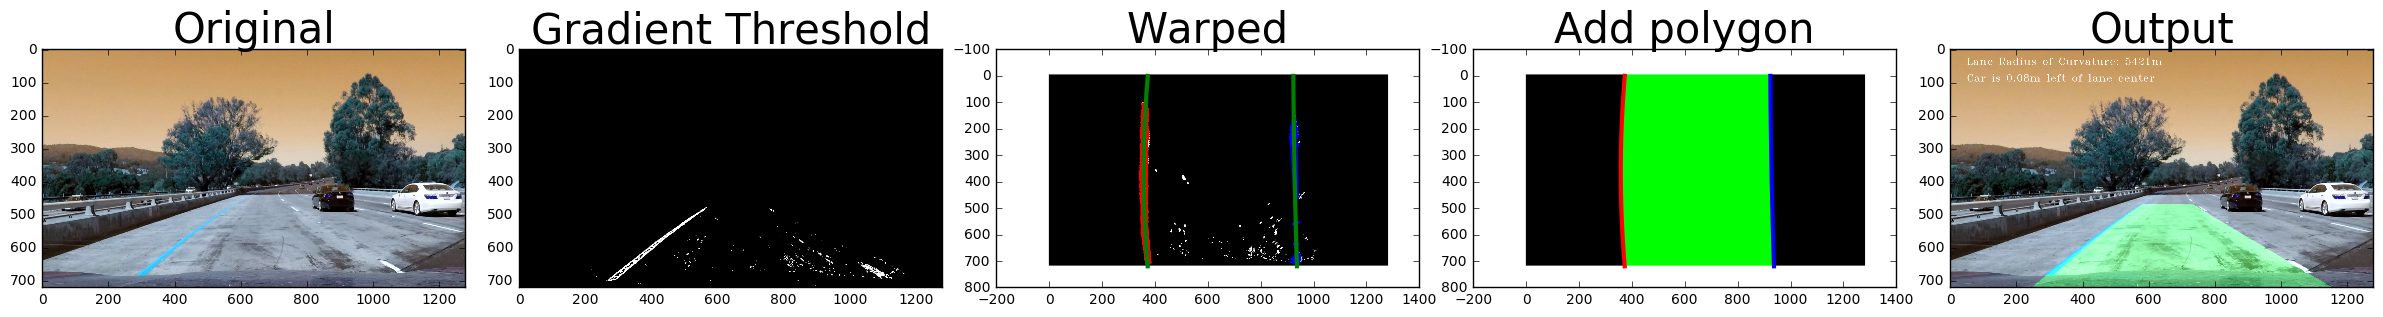

test_images\test2.jpg


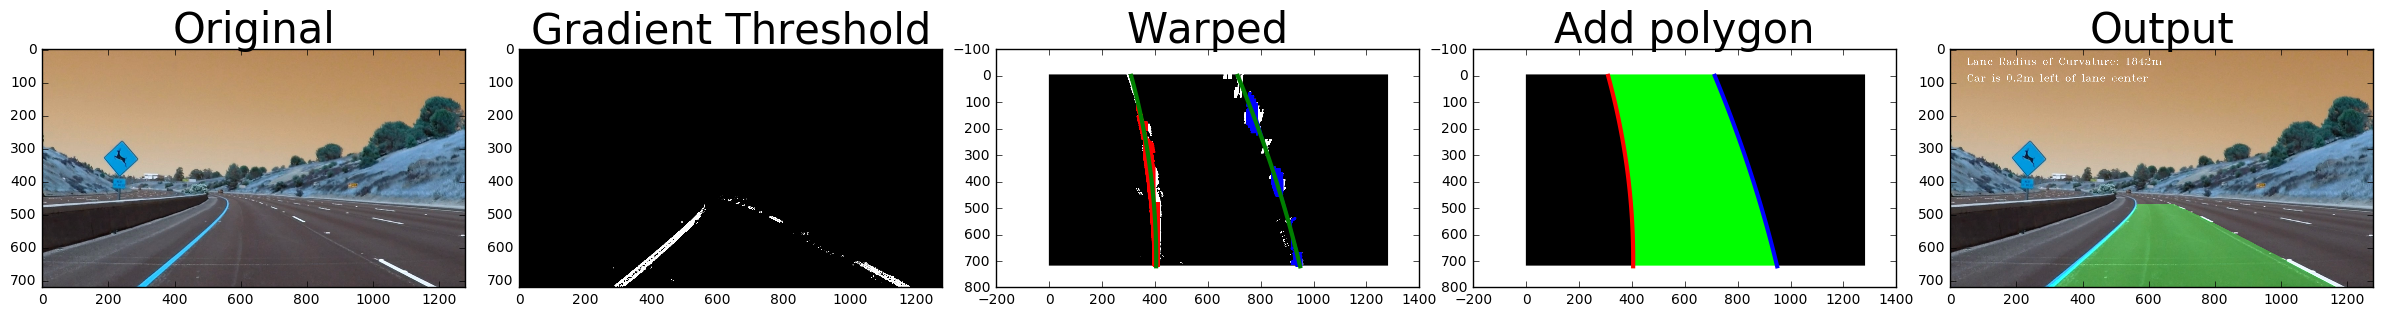

test_images\test3.jpg


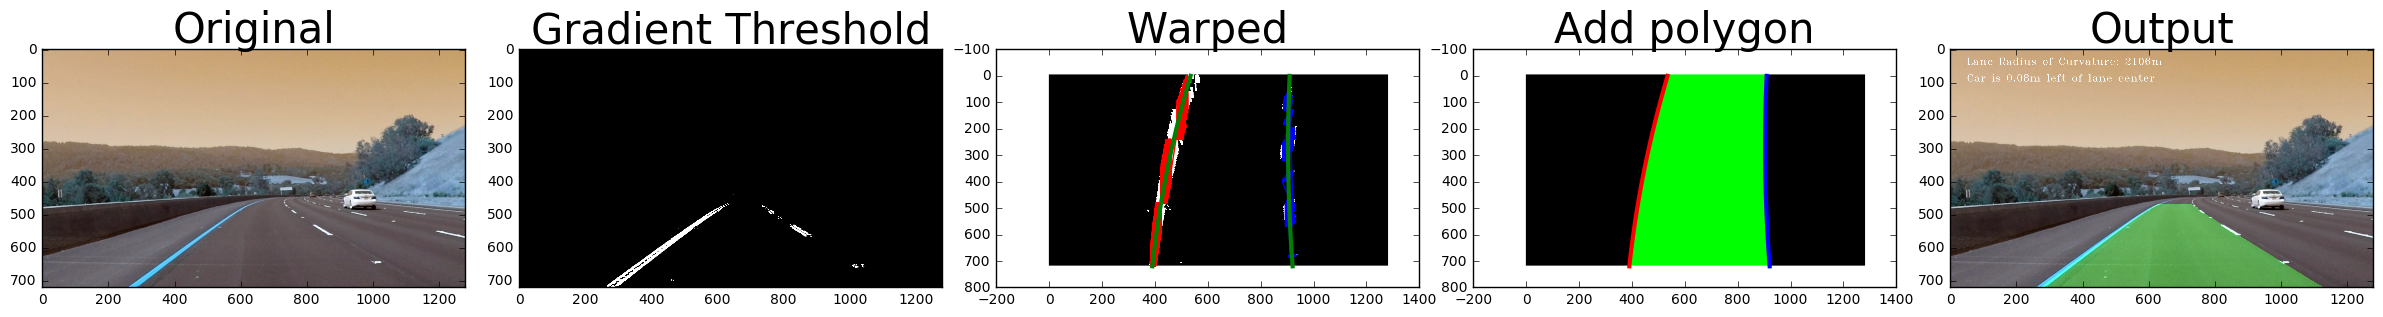

test_images\test4.jpg


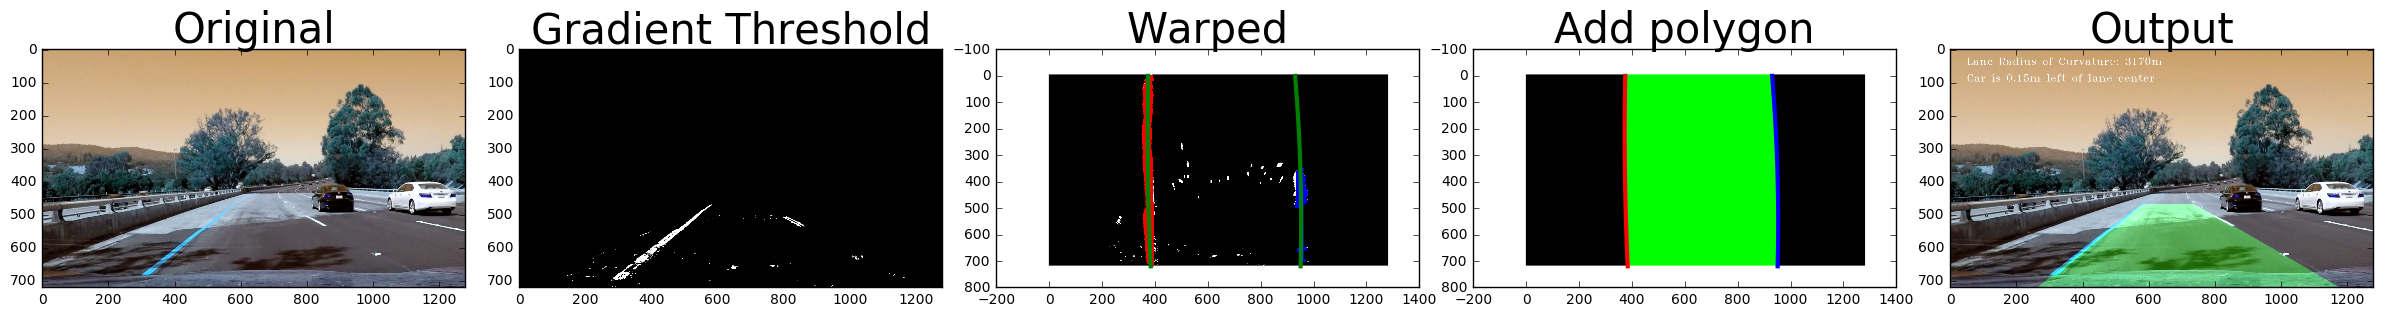

test_images\test5.jpg


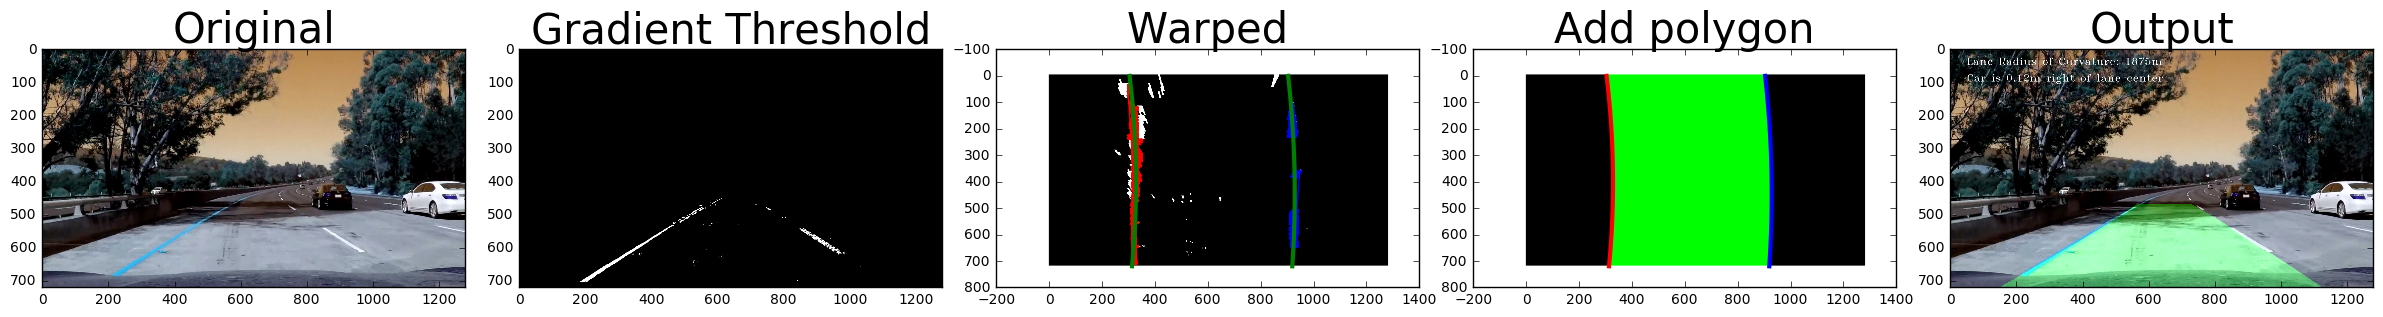

test_images\test6.jpg


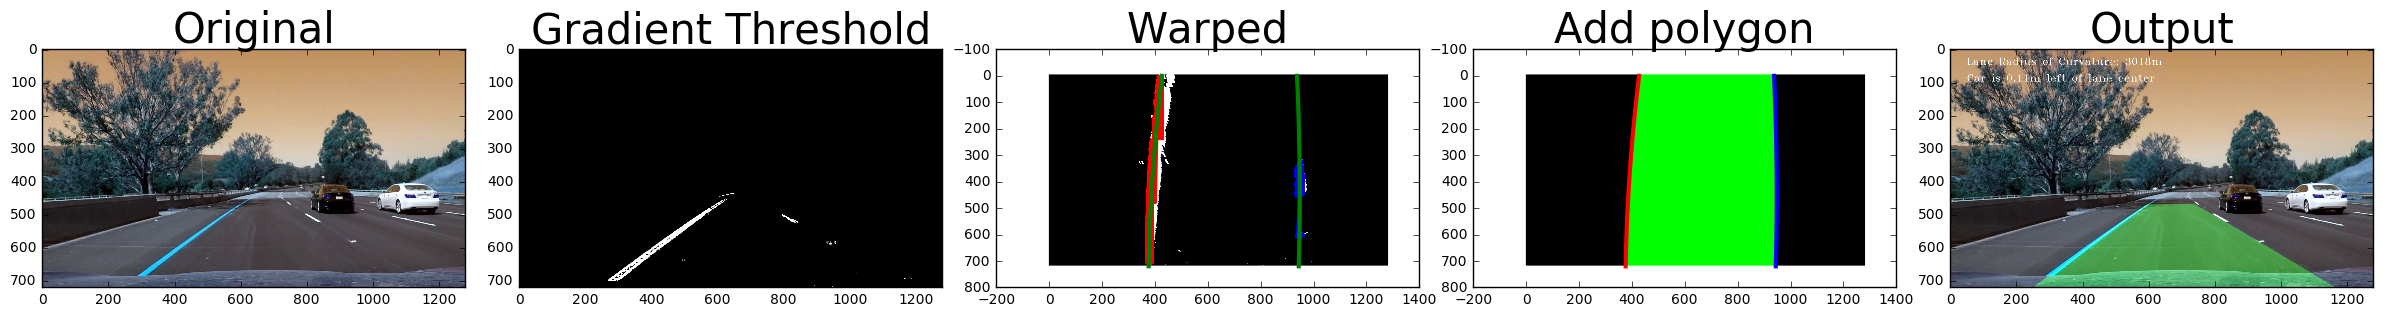

In [14]:
# Read in test images and iterate
images = glob.glob('test_images/test*.jpg')

for fname in images:
    
    print(fname)
    image = cv2.imread(fname)
    # Gradient threshold pipeline
    threshold, img_undst = threshold_pipeline(image)
    # Perspective transformation
    warped, Minv = perspective_transform(threshold, (image.shape[1], image.shape[0]))
    # Find lane points
    left_lane_pts, right_lane_pts = find_lane_pts(warped)
    # Fit the lane points
    left_fitx, right_fitx, yvals = fit_lanes(warped, left_lane_pts, right_lane_pts)
    # Draw polygon on warped image
    polyimage = draw_polygon(image, warped, left_fitx, right_fitx, yvals)
    # Find radius of curvature
    curve = (curvature(yvals, left_fitx) + curvature(yvals, right_fitx)) / 2
    # Find position
    pos = position(left_fitx, right_fitx, image.shape[1])
    # Draw the output image
    output = draw_output(image, polyimage, Minv, curve, pos)
    
    # Save interim and output images
    if str(ntpath.basename(fname)) == 'test2.jpg':
        # Undistorted road image
        fig = plt.imshow(img_undst)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.axis('off')
        plt.savefig('submission/examples/undistorted_' + ntpath.basename(fname),bbox_inches='tight')
        plt.clf()
        # Gradient threshold binary image
        fig = plt.imshow(threshold, cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.axis('off')
        plt.savefig('submission/examples/binary_' + ntpath.basename(fname),bbox_inches='tight')
        plt.clf()
        # Warped "bird's eye view" image
        fig = plt.imshow(warped, cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.axis('off')
        plt.savefig('submission/examples/warped_' + ntpath.basename(fname),bbox_inches='tight')
        plt.clf()
        # Warped bird's eye view with lane points and fitted lines
        fig = plt.imshow(warped, cmap='gray')
        plt.plot(left_lane_pts[:,1], left_lane_pts[:,0], color='red')
        plt.plot(right_lane_pts[:,1], right_lane_pts[:,0], color='blue')
        plt.plot(left_fitx, yvals, color='green', linewidth=3)
        plt.plot(right_fitx, yvals, color='green', linewidth=3)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.axis('off')
        plt.savefig('submission/examples/fitlines_' + ntpath.basename(fname),bbox_inches='tight')
        plt.clf()
        # Output image
        fig = plt.imshow(output)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.axis('off')
        plt.savefig('submission/examples/output_' + ntpath.basename(fname),bbox_inches='tight')
        plt.clf()
    
    # Visualize the results
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original', fontsize=30)
    ax1.imshow(image)
    ax2.set_title('Gradient Threshold', fontsize=30)
    ax2.imshow(threshold, cmap='bone')
    ax3.set_title('Warped', fontsize=30)
    ax3.imshow(warped, cmap='gray')
    ax3.plot(left_lane_pts[:,1], left_lane_pts[:,0], color='red')
    ax3.plot(right_lane_pts[:,1], right_lane_pts[:,0], color='blue')
    ax3.plot(left_fitx, yvals, color='green', linewidth=3)
    ax3.plot(right_fitx, yvals, color='green', linewidth=3)
    ax4.set_title('Add polygon', fontsize=30)
    ax4.imshow(polyimage)
    ax4.plot(left_fitx, yvals, color='red', linewidth=3)
    ax4.plot(right_fitx, yvals, color='blue', linewidth=3)
    ax5.set_title('Output', fontsize=30)
    ax5.imshow(output)
    plt.show()
    

In [15]:
#########################################################

# 3) Advanced Lane Finding on Videos

** Apply the pipeline to videos **

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Install ffmpeg with:
#import imageio
#imageio.plugins.ffmpeg.download()

### Define Line class to improve robustness

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # check for first frame of the video
        self.first = True
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.allx = None


### Line Verification

In [18]:
# Check that the lane lines are separated by approximately the right distance horizontally and roughly parallel
def line_check(left_fitx, right_fitx):
    
    # For first frame, initialize regardless of whether lanes pass the checks
    if left_lane.first == True:
        left_lane.allx = left_fitx
        left_lane.first = False
    if right_lane.first == True:
        right_lane.allx = right_fitx
        right_lane.first = False
    
    # Find the difference in x pixels between left and right lanes for each y value
    diff_x = right_fitx - left_fitx
    
    # Find the maximum and minimum distance between lanes on the warped image
    max_dist = max(diff_x)
    min_dist = min(diff_x)
    
    # Check that the lines are roughly parallel by whether max_dist and min_dist are close
    if (max_dist - min_dist) >= 115:
        left_fitx = left_lane.allx
        right_fitx = right_lane.allx
    # Check horizontal distance between lane lines
    elif min_dist < 400:
        left_fitx = left_lane.allx
        right_fitx = right_lane.allx
    else:
        # Assign most recent fitx since it passes the checks
        left_lane.allx = left_fitx
        right_lane.allx = right_fitx
        # Append to recent xfits
        left_lane.recent_xfitted.append(left_fitx)
        right_lane.recent_xfitted.append(right_fitx)
    
    # Average fitx over the last n frames to smooth the output polygon
    n = 10
    length = len(left_lane.recent_xfitted)
    if length > n:
        left_fitx = np.mean(left_lane.recent_xfitted[length-n:length], axis=0)
        right_fitx = np.mean(right_lane.recent_xfitted[length-n:length], axis=0)
    
    return left_fitx, right_fitx


### Video processing pipeline

In [19]:
# Convert the pipeline used for image testing into a function
# And add line checking and smoothing
def process_image(image):
    
    # Gradient threshold pipeline
    threshold, img_undst = threshold_pipeline(image)
    # Perspective transformation
    warped, Minv = perspective_transform(threshold, (image.shape[1], image.shape[0]))
    # Find lane points
    left_lane_pts, right_lane_pts = find_lane_pts(warped)
    # Fit the lane points
    left_fitx, right_fitx, yvals = fit_lanes(warped, left_lane_pts, right_lane_pts)
    # Double check that lines meet proper criteria and average across recent fitx
    left_fitx, right_fitx = line_check(left_fitx, right_fitx)
    # Draw polygon on warped image
    polyimage = draw_polygon(image, warped, left_fitx, right_fitx, yvals)
    # Find radius of curvature
    curve = (curvature(yvals, left_fitx) + curvature(yvals, right_fitx)) / 2
    # Find position
    pos = position(left_fitx, right_fitx, image.shape[1])
    # Draw the output image
    output = draw_output(image, polyimage, Minv, curve, pos)
    
    return output


### Process the video!

In [20]:
# Initialize lines
left_lane = Line()
right_lane = Line()

# Process the video
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) # Send each frame to process_image()
%time white_clip.write_videofile('project_video_output.mp4', audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:47<00:00,  5.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 47s


In [21]:
# More info and templates for this Udacity project can be found at https://github.com/udacity/CarND-Advanced-Lane-Lines